In [2]:
#import packages

import pandas as pd
import spacy
import nltk
import string
import re
import datetime
import spacy
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.model_selection import train_test_split
import en_core_web_sm
from spacy_readability import Readability
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [3]:
#read in the project data

df = pd.read_csv('project_data_complete.csv')
df.shape

(537, 38)

In [4]:
#delete unnecessary column

del df["Unnamed: 0"]

In [5]:
#remove dashes and slashes from punctuation we want to remove (we want to keep those for now)

punc = string.punctuation.replace('-', '').replace('/', '')

In [6]:
#remove all punctuation
df['Bio'] = df['Bio'].str.replace('[{}]'.format(punc), ' ').str.lower()

#remove slashes and replace with a space
df['Bio'] = df['Bio'].str.replace('/', ' ')

In [7]:
#create a string for each party 

dem_bios = ""
gop_bios = ""

#loop through and add the bios to each party
for index_label, row_series in df.iterrows():
    if row_series['party'] == "D":
        dem_bios = dem_bios + str(row_series["Bio"]) + " "
    elif row_series['party'] == "R":
        none = None
        gop_bios = gop_bios + str(row_series["Bio"]) + " "
    #there are two indepdents in Congress who caucus with the dems, but in future congresses this would need to be updated
    else:
        dem_bios = dem_bios + str(row_series["Bio"]) + " "
        df.at[index_label , 'party'] = "D"

In [8]:
#convert the partisan lean column into intergers

def get_int_value(lean):
    if "D" in lean:
        #dem leanings will be negative numbers
        num = int(re.findall('\d+|$', lean)[0])
        value = 0 - num
        return value
    elif "R" in lean:
        #GOP leanings will be positive
        num = int(re.findall('\d+|$', lean)[0])
        value = num
        return value
    else:
        return(0)
    
get_int_value("D+25.63")
        

-25

In [9]:
def fix_partisan_lean():
    for index_label, row_series in df.iterrows():
        #error to avoid places like DC / PR with no lean
        try:
            #get the string versions of lean
            lean_20 = row_series['partisan_lean_2020']
            #get the numeric value
            lean_20 = get_int_value(lean_20)
            #replace
            df.at[index_label, 'partisan_lean_2020'] = lean_20
        except:
            df.at[index_label, 'partisan_lean_2020'] = None

fix_partisan_lean()

In [10]:
# clean the data frame to remove memembers with no bio

clean_df = df.loc[~df['Bio'].isna()]

In [11]:
#make a dtm grouping by party affiliation

docs = [dem_bios, gop_bios]
vec = CountVectorizer()
X = vec.fit_transform(docs)
party_dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(),index = ['dem', 'gop'])
pd.options.display.max_rows = 40

In [12]:
#make a DTM of each member specifically

docs = clean_df["Bio"]
vec = CountVectorizer()
X = vec.fit_transform(docs)
member_dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(),index = clean_df["full_name"])
pd.options.display.max_rows = 40
member_pronoun_dtm = member_dtm[['he', 'him', 'his', 'she', 'her', 'hers']].sort_values(by=['he', 'him', 'his', 'she', 'her', 'hers'], ascending=False)

#add member_names as a column not an index
member_pronoun_dtm = member_pronoun_dtm.reset_index()

In [13]:
#add a column to clean_df as a binary indicator of pronouns
# we set it to zero to assume they do not

clean_df.insert(37, "has_pronouns", 0)

In [14]:
#here we bring back the members_pronouns DTM

member_pronoun_dtm.insert(7, "has_pronouns", 0)

In [15]:
# we want to avoid examples where pronouns are just used in conversation like "He will fight for your values"
# to do this we only add members who have at least two pronouns, since they show up in 2 or 3 sets like "he/him" or "he/him/his"

for index_label, row_series in member_pronoun_dtm.iterrows():
    name = row_series['full_name']
    male_value = row_series['he'] + row_series['him'] + row_series['his']
    if male_value > 1:
        member_pronoun_dtm.at[index_label, 'has_pronouns'] = 1

    female_value = row_series['she'] + row_series['her'] + row_series['hers']
    if female_value > 1:
        member_pronoun_dtm.at[index_label, 'has_pronouns'] = 1

In [16]:
#now we loop through clean_df and steal the values from member_pronouns_dtm

for index_label, row_series in clean_df.iterrows():
    #use the name to match
    name = row_series['full_name']
    #get the has_pronouns of that state 
    has_pronouns = member_pronoun_dtm.loc[member_pronoun_dtm['full_name'] == name, 'has_pronouns'].iloc[0]
    clean_df.at[index_label , 'has_pronouns'] = has_pronouns

In [23]:
#we can then manually check this shorter list and remove any that are not genuine examples of Preferred Gender Pronouns
clean_df[clean_df["has_pronouns"] == 1]
#we find that one member, August Pfluger, bio ust happens to use pronouns in his sentence twice so we'll manually set "has_pronouns" to 0
#his bio, for reference is: Colonel August Pfluger has dedicated his life to defending the U.S. and as our next Congressman, he’ll defend our traditional Texas values.
#472 is his index which we get from the above retunr
clean_df.at[472, "has_pronouns"] = 0

In [24]:
#define a list of religious words

religious_terms = ['christ',
                   "christian",
                   "jesus",
                   "god",
                   "holy spirt",
                   "bible",
                   "muslim",
                   "muslima",
                   "allah",
                   "islam",
                   "koran",
                   "quran",
                   "qur",
                   "imam",
                   "hindu",
                   "sikh",
                   'jew',
                   'jewish',
                   'judaism',
                   'rabbi',
                   'preacher',
                   'pastor',
                   'champlain',
                   'minister',
                   'priest'
                  ]

In [38]:
#add a religious column

clean_df.insert(38, "has_religion", 0)

In [26]:
#loop through the data frame, and if it has a religious word, set the binary to 1
for index_label, row_series in clean_df.iterrows():
    bio = row_series['Bio']
    words = bio.split(" ")
    for word in words:
        if word in religious_terms:
            clean_df.at[index_label, 'has_religion'] = 1

In [27]:
#Finally we created a tfidf matrix by party 
from sklearn.feature_extraction.text import TfidfVectorizer

docs = [dem_bios, gop_bios]
tfidf = TfidfVectorizer()
Y = tfidf.fit_transform(docs)
feats = tfidf.get_feature_names()
corpus_array = Y.toarray()
tfidf_matrix = pd.DataFrame(corpus_array, columns = feats, index = ['dem', 'gop'])
pd.options.display.max_columns = 100


In [46]:
#gather counts of each group
dem = len(clean_df[clean_df["party"] == "D"])
gop = len(clean_df[clean_df["party"] == "R"])
gop_pronoun = len(clean_df[(clean_df["party"] == "R") & (clean_df["has_pronouns"] == 1)])
gop_religion = len(clean_df[(clean_df["party"] == "R") & (clean_df["has_religion"] == 1)])
dem_pronoun = len(clean_df[(clean_df["party"] == "D") & (clean_df["has_pronouns"] == 1)])
dem_religion = len(clean_df[(clean_df["party"] == "D") & (clean_df["has_religion"] == 1)])
print(gop)
print(gop_pronoun)
print(gop_religion)
print(dem)
print(dem_pronoun)
print(dem_religion)

252
0
9
271
21
3


We'll get the age of each congressman and merge it to clean_df

In [30]:
# Get the birthdays and govtrack_id (to merge df's later)

birthday_govtrack = pd.read_csv('legislators-current.csv')[['birthday', 'govtrack_id']]
birthday_govtrack['birthday'] = birthday_govtrack['birthday'].str.split('/')
ages = []
for birthday in birthday_govtrack['birthday']:
    month, day, year = int(birthday[0]), int(birthday[1]), int('19'+birthday[2])
    #We can use the datetime module to get today's date, so in 20 days if a congressman turns older and we run this program, the age will adjust
    today = datetime.date.today()
    ages.append(today.year - year - ((today.month, today.day) < (month, day)))

#We can now append a list of ages onto the original df by merging the two dataframes by govtrack_id so we don't get any incorrect ages.
birthday_govtrack['age'] = ages
clean_df = pd.merge(clean_df, birthday_govtrack, on="govtrack_id", how='left')
clean_df = clean_df.rename(columns={"Follower Count": "follower_count"})

We will be running some binary linear regressions to find any good predictors for having pronouns/religious references in a bio

In [31]:
# We'll split our data between democrats and republicans to make these regressions easier to compute

linear_regressor = LinearRegression()
democrats = clean_df.loc[clean_df['party']=='D'].reset_index()
republicans = clean_df.loc[clean_df['party']=='R'].reset_index()
democrats['partisan_lean_2020'] = democrats['partisan_lean_2020'].fillna(0)
republicans['partisan_lean_2020'] = republicans['partisan_lean_2020'].fillna(0)
clean_df['partisan_lean_2020'] = clean_df['partisan_lean_2020'].fillna(0)
clean_df = clean_df.rename(columns={"Follower Count": "follower_count"})

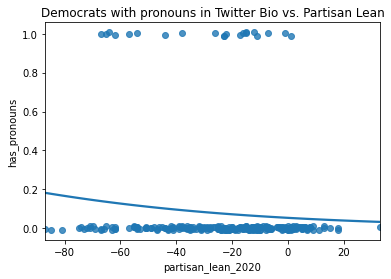

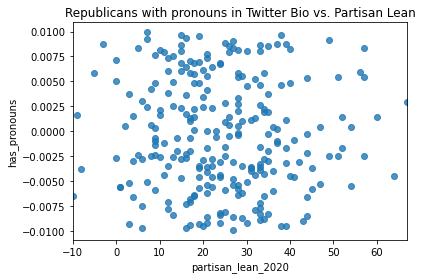

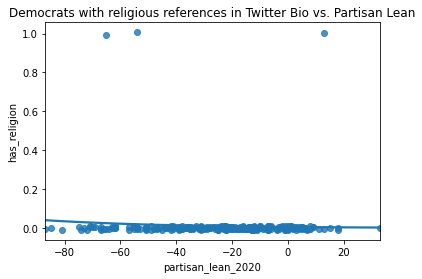

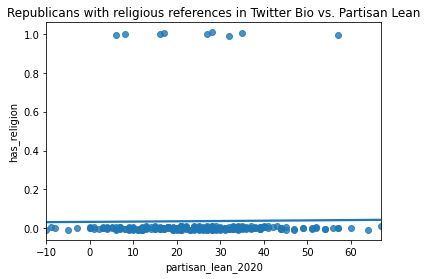

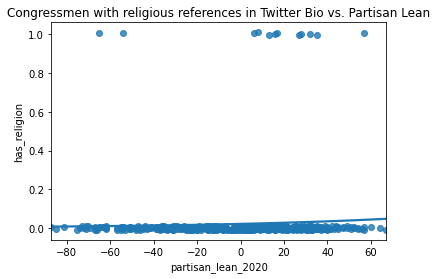

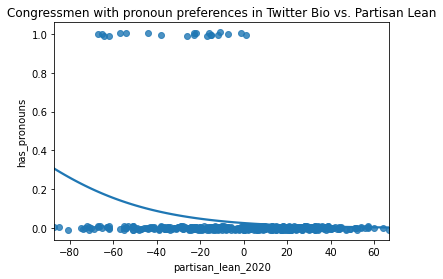

In [32]:
#The seaborn module allows us to plot histograms while also graphing a linear equation to show the relation between x and y.

sns.regplot(x='partisan_lean_2020', y='has_pronouns', y_jitter = 0.01, data=democrats,logistic=True, ci=None)
plt.title('Democrats with pronouns in Twitter Bio vs. Partisan Lean')
plt.show()
sns.regplot(x='partisan_lean_2020', y='has_pronouns', y_jitter = 0.01, data=republicans,logistic=True, ci=None)
plt.title('Republicans with pronouns in Twitter Bio vs. Partisan Lean')
plt.show()
sns.regplot(x='partisan_lean_2020', y='has_religion', y_jitter = 0.01, data=democrats,logistic=True, ci=None)
plt.title('Democrats with religious references in Twitter Bio vs. Partisan Lean')
plt.show()
sns.regplot(x='partisan_lean_2020', y='has_religion', y_jitter = 0.01, data=republicans,logistic=True, ci=None)
plt.title('Republicans with religious references in Twitter Bio vs. Partisan Lean')
plt.show()
sns.regplot(x='partisan_lean_2020', y='has_religion', y_jitter = 0.01, data=clean_df,logistic=True, ci=None)
plt.title('Congressmen with religious references in Twitter Bio vs. Partisan Lean')
plt.show()
sns.regplot(x='partisan_lean_2020', y='has_pronouns', y_jitter = 0.01, data=clean_df,logistic=True, ci=None)
plt.title('Congressmen with pronoun preferences in Twitter Bio vs. Partisan Lean')
plt.show()

We can clearly see there is no good linear regression line that accurately predicts whether or not politicians will have religious references or pronouns in their bio's according to partisan lean

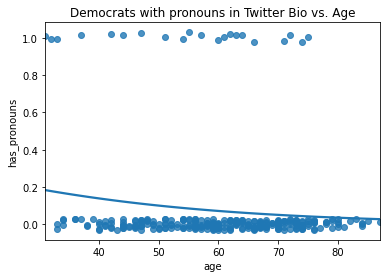

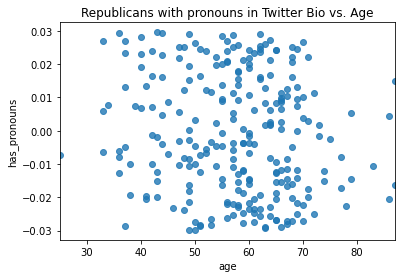

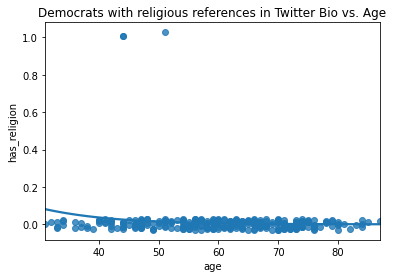

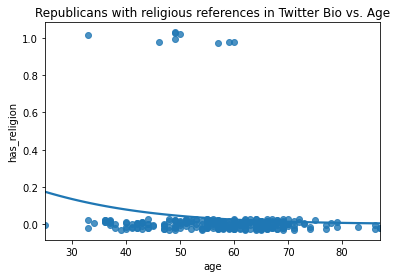

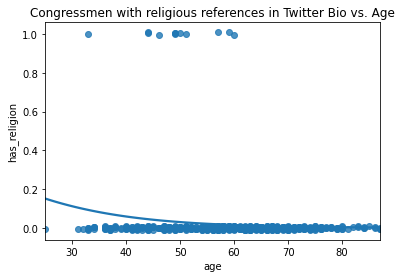

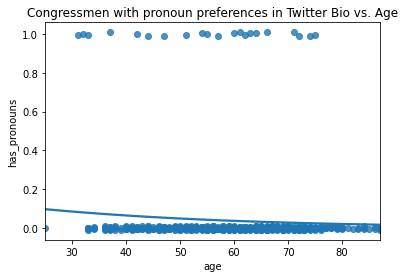

In [47]:
# We'll do the same as above, just now using a politicans age instead if their district lean to measure the outcomes

sns.regplot(x='age', y='has_pronouns', y_jitter = 0.03, data=democrats,logistic=True, ci=None)
plt.title('Democrats with pronouns in Twitter Bio vs. Age')
plt.show()
sns.regplot(x='age', y='has_pronouns', y_jitter = 0.03, data=republicans,logistic=True, ci=None)
plt.title('Republicans with pronouns in Twitter Bio vs. Age')
plt.show()
sns.regplot(x='age', y='has_religion', y_jitter = 0.03, data=democrats,logistic=True, ci=None)
plt.title('Democrats with religious references in Twitter Bio vs. Age')
plt.show()
sns.regplot(x='age', y='has_religion', y_jitter = 0.03, data=republicans,logistic=True, ci=None)
plt.title('Republicans with religious references in Twitter Bio vs. Age')
plt.show()
sns.regplot(x='age', y='has_religion', y_jitter = 0.01, data=clean_df,logistic=True, ci=None)
plt.title('Congressmen with religious references in Twitter Bio vs. Age')
plt.show()
sns.regplot(x='age', y='has_pronouns', y_jitter = 0.01, data=clean_df,logistic=True, ci=None)
plt.title('Congressmen with pronoun preferences in Twitter Bio vs. Age')
plt.show()

Same as above, there's not a good linear regression line to predict the outcomes

In [34]:
# We'll me doing a multiple regression where religion and pronouns are predicted given the same variables for republicans and democrats respectively.
# We first have to split our data between training and testing data

rep_train_data, rep_test_data = train_test_split(republicans, test_size = 0.2, random_state = 42)
dem_train_data, dem_test_data = train_test_split(democrats, test_size = 0.2, random_state = 42)
clean_df = clean_df.rename(columns={"Follower Count": "follower_count"})
rep_religion = ('has_religion ~ age + follower_count + partisan_lean_2020')
dem_pronouns = ('has_pronouns ~ age + follower_count + partisan_lean_2020')
model_rep_religion = logit(formula = rep_religion, data = rep_train_data).fit()
model_dem_pronouns = logit(formula = dem_pronouns, data = dem_train_data).fit()

Optimization terminated successfully.
         Current function value: 0.127786
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.218426
         Iterations 7


In [35]:
model_rep_religion.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           has_religion   No. Observations:                  201
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                 0.04796
Time:                        18:57:02   Log-Likelihood:                -25.685
converged:                       True   LL-Null:                       -26.979
Covariance Type:            nonrobust   LLR p-value:                    0.4596
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.2360      2.246     -0.996      0.319      -6.638       2.166
age                   -0.0404      0.039     -1.028      0.304      -0.117       0.037
follower_count     -2.394e-07   1.72e-06     -0.139      0.889   -3.61e-06    3.13e-06
partisan_lean_2020     0.0368      0.028      1.321      0.186      -0.018       0.091
======================================================================================
"""

In [36]:
model_dem_pronouns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           has_pronouns   No. Observations:                  216
Model:                          Logit   Df Residuals:                      212
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                  0.1339
Time:                        18:57:04   Log-Likelihood:                -47.180
converged:                       True   LL-Null:                       -54.475
Covariance Type:            nonrobust   LLR p-value:                  0.002202
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1218      1.227      0.099      0.921      -2.283       2.526
age                   -0.0573      0.022     -2.553      0.011      -0.101      -0.013
follower_count      2.841e-07    1.2e-07      2.360      0.018    4.82e-08     5.2e-07
partisan_lean_2020    -0.0144      0.011     -1.264      0.206      -0.037       0.008
======================================================================================
"""

Neither of the Binary Regression models performed well for us to use the variables in those regression equations to accurately predict if pronouns would be on a Democrat's bio, or religious references on a Republican's bio. 

In [37]:
# We will now test each party's readability in twitter Bio's using the Spacy module

rep_bios = ''.join(list(republicans['Bio'].values))
dem_bios = ''.join(list(democrats['Bio'].values))
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(Readability())
rep_spacy = nlp(rep_bios)
dem_spacy = nlp(dem_bios)
print('Republican Bios Readability Statistics\n')
print('Flesch Kincaid Grade Level: ', rep_spacy._.flesch_kincaid_grade_level)
print('Flesch Kincaid Reading Ease:  ',rep_spacy._.flesch_kincaid_reading_ease)
print('Dale Chall: ', rep_spacy._.dale_chall)
print('Coleman Liau Index: ', rep_spacy._.coleman_liau_index)
print('\n\nDemocrat Bios Readability Statistics\n')
print('Flesch Kincaid Grade Level: ', dem_spacy._.flesch_kincaid_grade_level)
print('Flesch Kincaid Reading Ease:  ',dem_spacy._.flesch_kincaid_reading_ease)
print('Dale Chall: ', dem_spacy._.dale_chall)
print('Coleman Liau Index: ', dem_spacy._.coleman_liau_index)


Republican Bios Readability Statistics

Flesch Kincaid Grade Level:  6.369434685680599
Flesch Kincaid Reading Ease:   71.77458291264404
Dale Chall:  14.2300955968261
Coleman Liau Index:  12.511563121821798


Democrat Bios Readability Statistics

Flesch Kincaid Grade Level:  5.854580331020085
Flesch Kincaid Reading Ease:   74.10830117704162
Dale Chall:  14.158010947007126
Coleman Liau Index:  11.095074977416438


Republican bios, by any measure, above, are harder to read than Democrat bios overall.